In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

from datetime import datetime, timedelta
from scipy.io import wavfile

%matplotlib inline

# Training Data Organization
The training data is located in the data directory of this repository and has the following structure:
- **signature_information.csv**: The file that contains every signature's metadata as well as the wav file that is associated with each row. Should be loaded as a Pandas Dataframe. 
- **target-run-logs.csv**: Contains all the information about every vehicle that was run in the experiments along with the target GPS log csv that is associated with each run. Some GPS files will span multiple runs, likely because the experiments took the same GPS model for vehicle to vehicle.
- **signatures directory**: Contains all the wav and xml files.
- **postion directory**: Contains all the GPS logs.

Now let's read in each of these files.

In [2]:
sig_info = pd.read_csv('../data/signature_information.csv')
run_info = pd.read_csv('../data/target-run-log.csv')

In [3]:
# Columns in signature information
list(sig_info.columns)

['location',
 'node-id',
 'date',
 'time',
 'sampling_rate',
 'mode',
 'sequence-number',
 'producer',
 'data-file',
 'up-time-seconds',
 'hw-config',
 'sw-mode',
 'status',
 'sensor-time-seconds',
 'sensor-time',
 'sample-rate-nominal',
 'sample-rate-actual',
 'lat',
 'lon',
 'alt-above-geoid-meters',
 'geoidal-separation-meters',
 'gps-fix-time-seconds',
 'gps-fix-time',
 'num-satellites']

In [4]:
print(sig_info.head())

  location  node-id        date      time  sampling_rate      mode  \
0     bprf      131  2023-04-12  17:25:00           1605   seismic   
1     bprf      131  2023-04-12  17:25:00           9865  acoustic   
2     bprf      131  2023-04-10  18:25:00           1605   seismic   
3     bprf      131  2023-04-10  18:30:00           9867  acoustic   
4     bprf      131  2023-04-10  18:25:00           9865  acoustic   

   sequence-number                                           producer  \
0               53  Sensor version 80 UPDATE 2, compiled at Mar  1...   
1               53  Sensor version 80 UPDATE 2, compiled at Mar  1...   
2               55  Sensor version 80 UPDATE 2, compiled at Mar  1...   
3               56  Sensor version 80 UPDATE 2, compiled at Mar  1...   
4               55  Sensor version 80 UPDATE 2, compiled at Mar  1...   

                                       data-file  up-time-seconds  ...  \
0  Node131-Ch2-53-2023_04_12_17_25_00-1605Hz.wav            15787 

In [5]:
# Columns in target run information
list(run_info.columns)

['location',
 'date',
 'run',
 'make',
 'model',
 'year',
 'type',
 'target-name',
 'target-id',
 'speed-kph',
 'speed-throttle',
 'direction',
 'start-time-utc',
 'mads-cpa-utc',
 'stop-time-utc',
 'gps-log-file',
 'comments',
 'nsin-release',
 'east-start-turnaround-lat',
 'east-start-turnaround-lon',
 'west-start-turnaround-lat',
 'west-start-turnaround-lon',
 'north-start-turnaround-lat',
 'north-start-turnaround-lon',
 'south-start-turnaround-lat',
 'south-start-turnaround-lon']

In [6]:
print(run_info.head())

  location       date  run       make    model    year type  \
0    eglin  3/16/2023    1     Toyota   Tacoma  2006.0  SR5   
1    eglin  3/16/2023    1  Chevrolet     S-10  1995.0  NaN   
2  cochise  4/10/2023    1     Toyota  4Runner     NaN  NaN   
3  cochise  4/10/2023    2     Toyota  4Runner     NaN  NaN   
4  cochise  4/10/2023    3     Toyota  4Runner     NaN  NaN   

              target-name target-id  speed-kph  ...      comments  \
0  2006 Toyota Tacoma SR5        1A       25.0  ...  Convoy Veh 1   
1     1995 Chevrolet S-10        1B       25.0  ...  Convoy Veh 2   
2          Toyota 4Runner        3A       20.0  ...           NaN   
3          Toyota 4Runner        3A       20.0  ...           NaN   
4          Toyota 4Runner        3A       20.0  ...           NaN   

              nsin-release east-start-turnaround-lat  \
0  2 - Developers Data Set                       NaN   
1  2 - Developers Data Set                       NaN   
2  2 - Developers Data Set            

Lastly, we need to do a little bit of processing to but some of the columns in the right format.

In [7]:
sig_info['datetime'] = pd.to_datetime(sig_info['date'] + ' ' + sig_info['time'], format='%Y-%m-%d %H:%M:%S')
sig_info['date'] = pd.to_datetime(sig_info['date'], format='%Y-%m-%d')
sig_info['time'] = pd.to_datetime(sig_info['time'], format='%H:%M:%S')
sig_info['sensor-time'] = pd.to_datetime(sig_info['sensor-time'])
sig_info['gps-fix-time'] = pd.to_datetime(sig_info['gps-fix-time'])
run_info['start-datetime'] = pd.to_datetime(run_info['date'] + ' ' + run_info['start-time-utc'], format='mixed', yearfirst=True)
run_info['stop-datetime'] = pd.to_datetime(run_info['date'] + ' ' + run_info['stop-time-utc'], format='mixed', yearfirst=True)
run_info['date'] = pd.to_datetime(run_info['date'])
run_info['start-time-utc'] = pd.to_datetime(run_info['start-time-utc'], format='mixed').apply(lambda value: value.time()) 
run_info['stop-time-utc'] = pd.to_datetime(run_info['stop-time-utc'], format='mixed').apply(lambda value: value.time()) 

# Example Acoustic Analysis
Now that we have loaded the metadata from both the signature files and target runs, we can begin with a sample acoustic analysis to explore what types of signatures can be deduced from a vehicle presence or not. 

Let's begin by processing the entire Eglin audio stream from a single sensor, i.e., sensor 80. 

In [8]:
# Focus on sensor 80 and sort on datetime
eglin_signatures_80 = sig_info[(sig_info['location'] == 'eglin') & (sig_info['mode'] == 'acoustic') & (sig_info['node-id'] == 80)].sort_values('datetime')

In [9]:
# Now let's collect and read in all these signatures into a single audio file
SIGNATURES_ROOT = '../data/signatures/'
rate = None
audio_data = []
for i, row in eglin_signatures_80.iterrows():
    wav = os.path.join(SIGNATURES_ROOT, row['data-file'])
    _rate, _data = wavfile.read(wav)
    if not rate:
        rate = _rate
    if rate != _rate:
        print('Warning: Rates not equal')
    audio_data.append(_data)
audio_data = np.concatenate(audio_data)

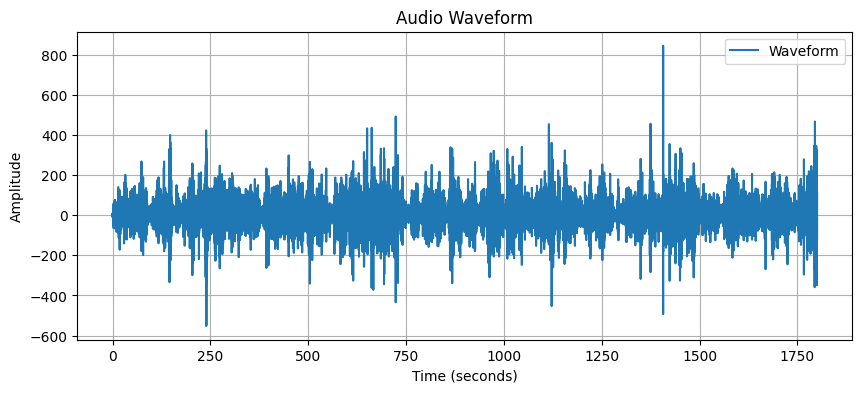

In [10]:
# Create a time axis in seconds
time = np.linspace(0, len(audio_data) / rate, num=len(audio_data))

# Plotting the audio data
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, label='Waveform')
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Now, let's map in the locations where the vehicles are driving, i.e., start and end times of the runs. 

/home/chase/src/research/projects/goodvibes/goodvibes-venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


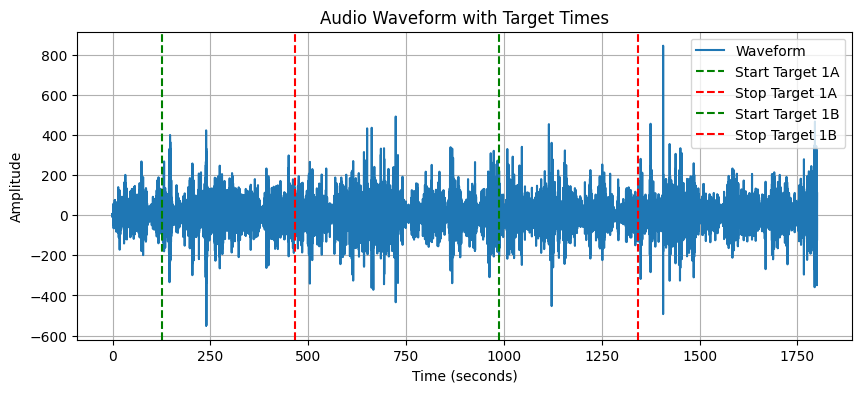

In [11]:
# Get the audio start time for reference
audio_start_datetime = eglin_signatures_80['datetime'].iloc[0]

# Eglin Targets
targets = run_info[run_info['location'] == 'eglin']['target-id'].unique()
start_points = []
stop_points = []
for target in targets:
    start_datetime = run_info[(run_info['location'] == 'eglin') & (run_info['target-id'] == target)]['start-datetime'].iloc[0] - audio_start_datetime
    stop_datetime = run_info[(run_info['location'] == 'eglin') & (run_info['target-id'] == target)]['stop-datetime'].iloc[0] - audio_start_datetime

    # Convert to seconds since the start of the audio file
    start_seconds = start_datetime.total_seconds()
    stop_seconds = stop_datetime.total_seconds()

    # Append to lists
    start_points.append(start_seconds)
    stop_points.append(stop_seconds)

plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, label='Waveform')
plt.title('Audio Waveform with Target Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Plotting start and stop points
for start, stop, target in zip(start_points, stop_points, targets):
    plt.axvline(x=start, color='green', linestyle='--', label=f'Start Target {target}')
    plt.axvline(x=stop, color='red', linestyle='--', label=f'Stop Target {target}')

plt.legend()
plt.grid(True)
plt.show()

## Frequency spectrum of targets
Now let's look at the FFT of each target during it's run frequency and compare that with the frequency sprectrum of no run time to see if there is anything of interest. 

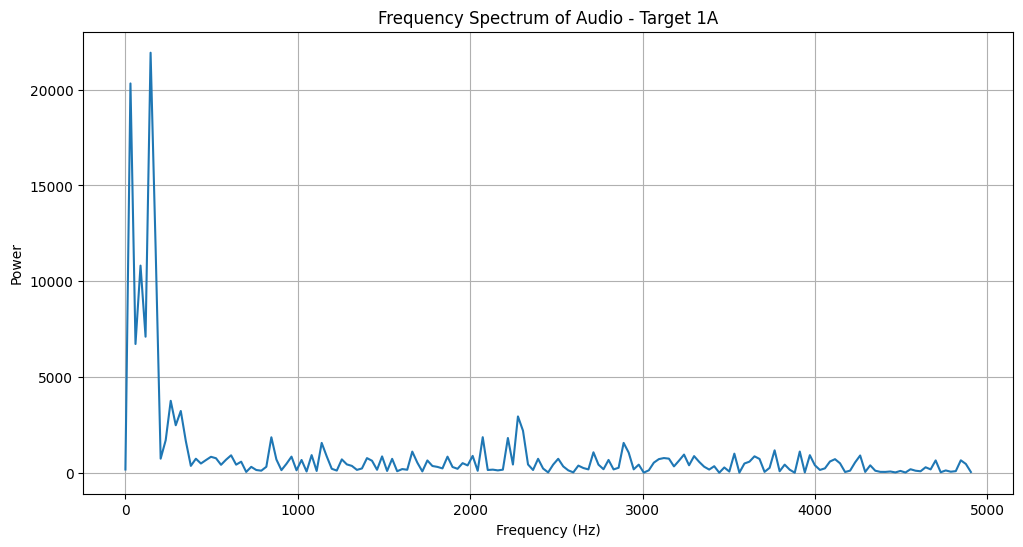

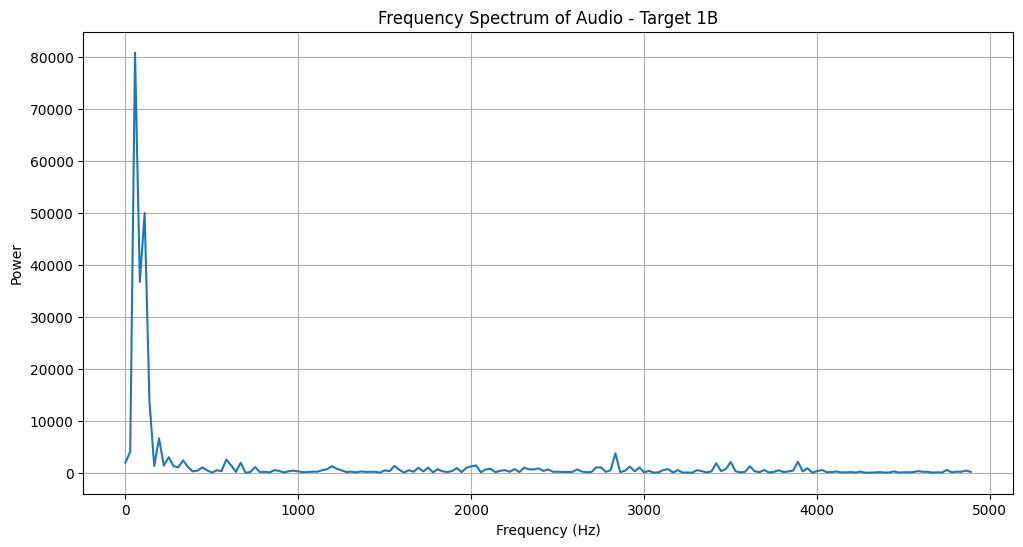

In [12]:
for start, stop, target in zip(start_points, stop_points, targets):
    fft_data = np.fft.fft(audio_data[int(start):int(stop)])
    
    # Get the power spectrum
    power = np.abs(fft_data)**2
    
    # Generate frequency axis
    frequencies = np.fft.fftfreq(len(fft_data), 1 / rate)
    
    # Only plot the first half of the FFT, since it's symmetric
    half_range = len(frequencies) // 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:half_range], power[:half_range])
    plt.title(f'Frequency Spectrum of Audio - Target {target}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.show()

## Frequency spectrum of noise
Now let's look at the FFT of each period with no target running.

[0, 465.0, 1343.0]
[127.0, 988.0, -50]


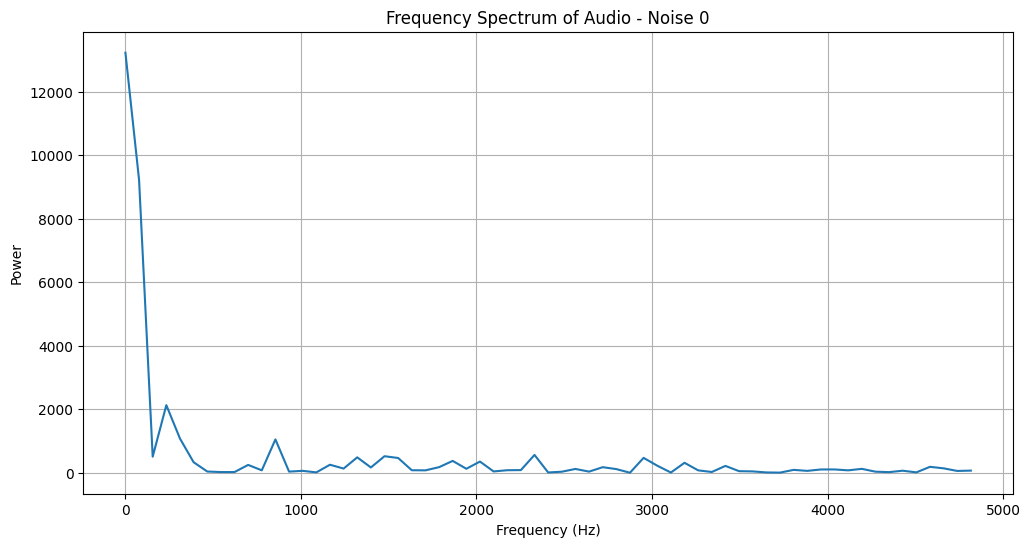

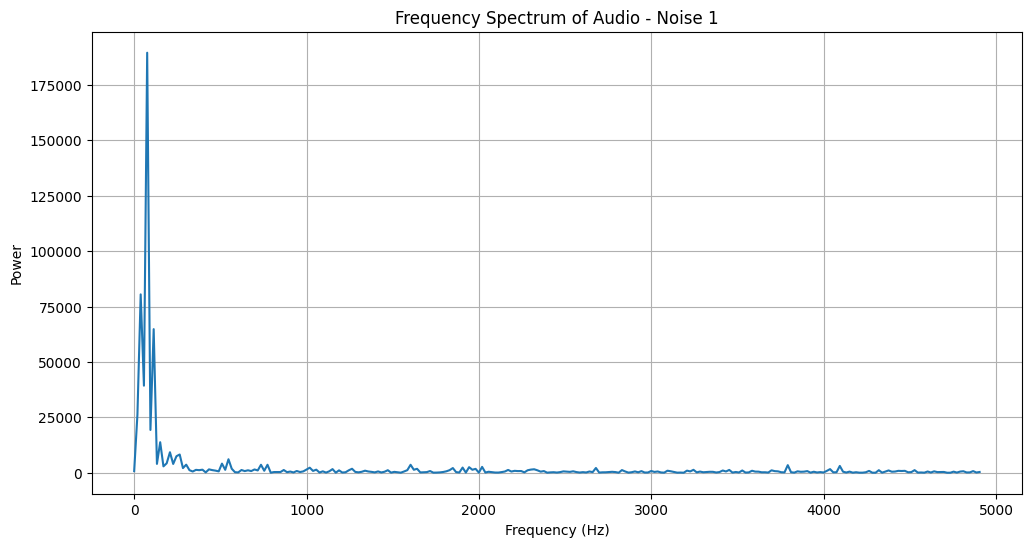

In [ ]:
noise_start_points = [0] + stop_points
noise_stop_points = start_points + [-50]
print(noise_start_points)
print(noise_stop_points)

for i, (start, stop) in enumerate(zip(noise_start_points, noise_stop_points)):
    fft_data = np.fft.fft(audio_data[int(start):int(stop)])
    
    # Get the power spectrum
    power = np.abs(fft_data)**2
    
    # Generate frequency axis
    frequencies = np.fft.fftfreq(len(fft_data), 1 / rate)
    
    # Only plot the first half of the FFT, since it's symmetric
    half_range = len(frequencies) // 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:half_range], power[:half_range])
    plt.title(f'Frequency Spectrum of Audio - Noise {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.show()